# A neural network model for regression problems

We will see here how to use Keras to implement a simple neural network model for a **regression problem** (continuous target variable). 
For this practical session we are using the [Boston house princing dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), exploring the relationship between house prices (in thousands of dollars) and a series of thirteen numerical properties of houses in Boston suburbs.

Fortunately for us, is a very well known dataset, handily included in the [sklearn library](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

# The usual seed priming

In [2]:
#general random seed
from numpy.random import seed
seed(10)

#tensorflow-specific seed. If you want to know why
#we need to set two separate random seeds see
#https://blog.cmgresearch.com/2020/09/04/tensorflow-has-to-random-seeds.html
import tensorflow
tensorflow.random.set_seed(10)

# Loading libraries and getting the data

We first load some necessary libraries and get the data from the `github` repository

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

(features, target_variable) = datasets.load_boston(return_X_y=True)

#for data description and manipulation a pandas dataframe is handier
#than a numpy matrix. Moreover, you can always go back using .to_numpy()
#method
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html
features = pd.DataFrame(features)

# Data description

In [3]:
#taking a look at the features
features.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


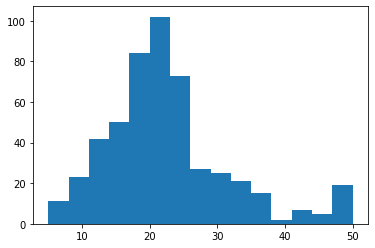

In [4]:
#taking a look at the target variable
plt.hist(target_variable, bins = 15)
plt.show()

# Data preprocessing

## Missing values removal

It's always useful to check if something is missing, since usually regression models don't like missing values.

In [5]:
features.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

No values are missing, but just in case the code belows takes care of holes in the features data frame.

In [6]:
#fast way, but only for one data frame...
#features = features.dropna()

#finding features with at least one missing data point
missing = features.isnull().sum(axis = 1) > 0

#you cannot simply use the "not" operator on a series
#it's ambigous. We need to pass through a proper
#negation function from numpy
not_missing = np.logical_not(missing)

#subsetting
features = features.loc[not_missing, :]
target_variable = target_variable[not_missing]

#just checking
print("Size of target variable: ", target_variable.shape)
print("Size of feature matrix: ", features.shape)

Size of target variable:  (506,)
Size of feature matrix:  (506, 13)


## Discussion: what if we are missing target values?

The code above shows us how to remove samples with missing values in the `features` data frame. What if we have missing values in the target array?

Pay attention: `target_variable` is a NumPy array. What kind of data should we expect?

## Discussion: outliers removal?

Should we remove outliers data? If yes, do it in the space below. If no, tell us why.

In [7]:
######## YOUR CODE HERE ########
if False:
  #some very refined logic...
  outlier = target_variable > 40

  #subsetting
  features = features.loc[np.logical_not(outlier), :]
  target_variable = target_variable[np.logical_not(outlier)]

  #just checking
  print("Size of target variable: ", target_variable.shape)
  print("Size of feature matrix: ", features.shape)
################################

## Discussion/Exercise: data normalization?

Should we normalize the features? If yes, do it in the space below. If no, tell us why.

In [ ]:
######## YOUR CODE HERE ########
if False:
  #getting mean and standard deviation for train set
  avg = features.mean()
  std = features.std()

  #normalizing
  features = (features - avg)/std

  #checking if we are doing everything fine
  print(pd.DataFrame(features).describe())
################################

# Training and validation sets

We have a resonable-sized dataset, we can go with one of the standard split-validation cuts, e.g. 10% 

> **[PRO TIP]** In very small dataset you may be forced to do "leave one out" crossvalidation. For N samples you cycle selecting one sample for predictions (this would be your validation set) and keeping N-1 for training. Unfortunately in this case you cannot compute correlations (can you guess why?) and must use error-related metrics like Mean Squared Error.




In [8]:
#we import a function to perform the split
from sklearn.model_selection import train_test_split

features_train, features_val, target_train, target_val = train_test_split(features, target_variable, test_size=0.10)
    
#let's print some shapes to get an idea of the resulting data structure
print(features_train.shape)
print(features_val.shape)
print(target_train.shape)
print(target_val.shape)

(455, 13)
(51, 13)
(455,)
(51,)


# Building the neural networks model

We are now ready to build our neural networks model for regression. First, we set some hyperparameters:

- the activation function in the output layer in this case is **linear**: we get directly the results from $\sum wx + b$ 
- the loss function is MSE (**Mean Squared Error**)

In [9]:
# Configuration options

#Keras wants the data shape as a tuple. In case of images is something 
#like (image width, image height, number of channels). 
#In our case data is tabular so each data point is an 
#array (a row in the table) and we just need to specify 
#a single number, i.e. the number of columns. However, we still need
#to input a tuple, so...
input_shape = (features.shape[1],) 

#other standard features describing our network
hidden_nodes = 16
hidden_activation = 'relu'
output_activation = 'linear'
loss_function = 'mean_squared_error'
optimizer_used = 'rmsprop'
num_epochs = 10

In [10]:
print(input_shape)

(13,)


As we learnt to do throughout the course, we now use `keras` to build our sequential neural networks model:

In [11]:
#we are building a "sequential" model, meaning that the data will 
#flow like INPUT -> ELABORATION -> OUTPUT.
from keras.models import Sequential

#a "dense" layer is a layer were all the data coming in are connected
#to all nodes.
from keras.layers import Dense

#adding the hidden layer with the required number of nodes, plus the final
#layer with a single node (since we want to output a single number)
model = Sequential()
model.add(Dense(units=hidden_nodes, input_shape=input_shape, activation=hidden_activation))
model.add(Dense(1, activation=output_activation))

#the model is declared, but we still need to compile it to actually
#build all the data structures
model.compile(optimizer=optimizer_used, loss=loss_function)

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________
None


The `model.summary()` tells us that we now have 145 model parameters to learn: 

- hidden layer: 7 feature weights x 16 units + 16 bias terms $\rightarrow$ 128 parameters
- output layer: 16 unit weights + 1 bias term $\rightarrow$ 17 parameters  
- 128 + 17 = 145 parameters

# Training the neural network model

In [13]:
history = model.fit(
    features_train, target_train, 
    epochs=num_epochs, validation_data=(features_val, target_val), verbose = 0)

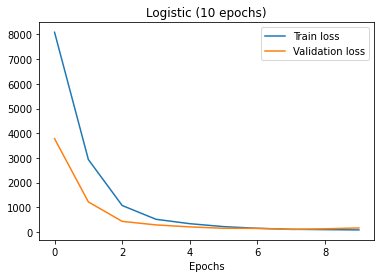

In [14]:
def plot_loss_history(h, title):
    plt.plot(h.history['loss'], label = "Train loss")
    plt.plot(h.history['val_loss'], label = "Validation loss")
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

plot_loss_history(history, 'Logistic ({} epochs)'.format(num_epochs))

# Predictions

We can now see the predictions our neural networks model produced for the house prices. Below we report also the known target values from the test set 

In [15]:
#predicting, and reporting the shape of the obtained object (also known as y hat)
predictions = model.predict(features_val)
print(predictions.shape)

(51, 1)


In [16]:
#a couple of print on true target values (also known as y)
print(target_val)
print(target_val.shape)

[28.4 31.1 23.5 26.6 19.6 14.3 50.  14.3 20.7 37.6 20.4 27.5 36.2 32.
 33.1 48.8 24.6 26.4 23.2 17.  41.3 14.9 18.5 25.  36.4 19.5 27.1 14.9
 46.  17.9 30.3 31.6 23.1 24.7 16.7 18.3  8.4 37.3 22.1 22.  46.7 30.1
 12.1 29.1 16.6 23.9 19.9 21.4 45.4 15.6 22.7]
(51,)


In regression problems you can not use the same accuracy metrics as in classification problems (e.g. error rate, confusion matrix, etc.): in stead, other metrics are used like:

- **Pearson linear correlation**
- **Spearman rank correlation**
- **RMSE** (root mean squared error)
- **MAE** (mean absolute error)
- etc. (there are many more)

In [17]:
#changing forma to pandas Series, for handiness
y_pred = pd.Series(predictions[:,0])
y = pd.Series(target_val)

#computing correlation
accuracy = y.corr(y_pred, method='pearson')
print("accuracy (measured as Pearson's correlation) is: ", accuracy)

accuracy (measured as Pearson's correlation) is:  0.3383863961451896



A scatter plot of predicted vs true values can also be useful to visualise the result of the model:



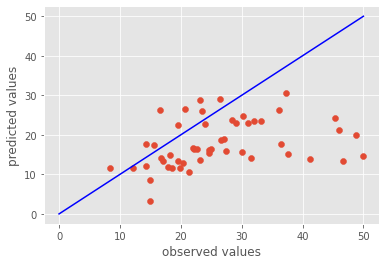

In [18]:
plt.style.use('ggplot')

plt.scatter(y, y_pred)
#equivalent: plt.plot(y, y_pred, "o")

# draw the main diagonal, for reference
plt.plot([0, 50], [0, 50], color='b')

#labelling the axis
plt.xlabel("observed values")
plt.ylabel("predicted values")

plt.show()

In [19]:
#Root Mean Square Error
print('Root Mean Square Error : ' + str(np.sqrt(sum((y-y_pred)**2)/len(y))))
print('Target mean            : ' + str(y.mean()))
print('Predictions mean       : ' + str(y_pred.mean()))

Root Mean Square Error : 12.75689091854338
Target mean            : 26.172549019607843
Predictions mean       : 17.884374618530273


# Exercise: improve the network

The predictions are not terrible but for sure not excellent. How to improve the performances?